In [9]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [10]:

#Importation des bibliothèques

from dotenv import load_dotenv
import os
import sys
import requests
import json
import logging
import time
import pandas as pd
from pandas import json_normalize
import geopandas as gpd
from io import StringIO
import seaborn as sns
import folium
import json
import requests
import time

In [11]:
load_dotenv()  # Charge les variables d'environnement du fichier .env

APPLICATION_ID= os.getenv("APPLICATION_ID")

In [12]:

import json
import requests
import time


logging.captureWarnings(True)
# Example of a Python implementation for a continuous authentication client.
# It's necessary to :
# - update APPLICATION_ID
# - update request_url at the end of the script

# unique application id : you can find this in the curl's command to generate jwt token 
APPLICATION_ID = 'Q2Y4QzFxODZ6Ukd4VWhjNzY0aWpOc1NmM1dFYTp3OGdxNXhhMDY5dDl0OXJudFdPYjRveGpzbzBh'

# url to obtain acces token
TOKEN_URL = "https://portail-api.meteofrance.fr/token"

class Client(object):

    def __init__(self):
        self.session = requests.Session()

    def request(self, method, url, **kwargs):
        # First request will always need to obtain a token first
        if 'Authorization' not in self.session.headers:
            self.obtain_token()

        # Optimistically attempt to dispatch reqest
        response = self.session.request(method, url, **kwargs)
        if self.token_has_expired(response):
            # We got an 'Access token expired' response => refresh token
            self.obtain_token()
            # Re-dispatch the request that previously failed
            response = self.session.request(method, url, **kwargs)

        return response

    def token_has_expired(self, response):
        status = response.status_code
        content_type = response.headers['Content-Type']
        repJson = response.text
        if status == 401 and 'application/json' in content_type:
            repJson = response.text
            if 'Invalid JWT token' in repJson['description']:
                return True
        return False

    def obtain_token(self):
        # Obtain new token
        data = {'grant_type': 'client_credentials'}
        headers = {'Authorization': 'Basic ' + APPLICATION_ID}
        access_token_response = requests.post(TOKEN_URL, data=data, verify=False, allow_redirects=False, headers=headers)
        token = access_token_response.json()['access_token']
        # Update session with fresh token
        self.session.headers.update({'Authorization': 'Bearer %s' % token})

client = Client()
 # Issue a series of API requests an example. For use this test, you must first subscribe to the arome api with your application
client.session.headers.update({'Accept': 'application/json'})

In [13]:
#on récupère la liste des stations
station=client.request('GET', 'https://public-api.meteofrance.fr/public/DPObs/v1/liste-stations', verify=False)



data = StringIO(station.text)
print(data)
df = pd.read_csv(data,sep=';')

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs=4326
)
gdf
#On récupere la liste des stations climatologiques envoant les mesures à une fréquence de 1 journée
client = Client()
 # Issue a series of API requests an example. For use this test, you must first subscribe to the arome api with your application
client.session.headers.update({'Accept': 'application/json'})
response = client.request('GET', 'https://public-api.meteofrance.fr/public/DPClim/v1/liste-stations/infrahoraire-6m?id-departement=91', verify=False)
df=pd.DataFrame(response.json())
print(df.head())


         id            nom  posteOuvert  typePoste       lon        lat  alt  \
0  91027002           ORLY         True          0  2.397000  48.718000   86   
1  91069001    BOIGNEVILLE        False          2  2.381167  48.325500  115   
2  91103001  BRETIGNY_SAPC         True          2  2.326000  48.600500   78   
3  91184001   COURDIMANCHE         True          1  2.374333  48.421833   71   
4  91200002        DOURDAN         True          1  1.993000  48.526167  116   

   postePublic  
0         True  
1         True  
2         True  
3         True  
4         True  


In [14]:

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326
)
gdf

center=gdf[["lat", "lon"]].mean().values.tolist()
def interactive_map_dpe(dpe):

    center = dpe[["lat", "lon"]].mean().values.tolist()
    sw = dpe[["lat", "lon"]].min().values.tolist()
    ne = dpe[["lat", "lon"]].max().values.tolist()

    m = folium.Map(location=center, tiles="OpenStreetMap")

    # I can add markers one by one on the map
    for i in range(0, len(dpe)):
        folium.Marker(
            [dpe.iloc[i]["lat"], dpe.iloc[i]["lon"]],
            icon=folium.Icon(
                color="black", icon="cloud"
            ),
        ).add_to(m)

    m.fit_bounds([sw, ne])

    return m


m = interactive_map_dpe(gdf)
m

In [15]:
def gener_idcommande(datedebut,datefin):

   client=Client()
   response1 = client.request('GET', 'https://public-api.meteofrance.fr/public/DPClim/v1/commande-station/quotidienne?id-station=01014002&date-deb-periode={}T14%3A30%3A00Z&date-fin-periode={}T14%3A30%3A00Z'.format(datedebut,datefin), verify=False)
   response1=response1.json()
   #print(response1)
   return int((response1.get('elaboreProduitAvecDemandeResponse')).get('return'))




gener_idcommande("2024-11-01","2024-11-05")

client=Client()
datameteo=client.request('GET',"https://public-api.meteofrance.fr/public/DPClim/v1/commande/fichier?id-cmde={}".format(gener_idcommande("2024-11-01","2024-11-05")),verify=False)


data = StringIO(datameteo.text)
print(data)
df = pd.read_csv(data,sep=';')
missing_columns = df.isnull().sum() > 0
num_missing_columns = missing_columns.sum()

print(f"Nombre de colonnes avec des valeurs manquantes : {num_missing_columns}")

Nombre de colonnes avec des valeurs manquantes : 37


# ANALYSE EXPLORATOIRE


In [16]:
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

It contains 5 rows and 69 columns.


,POSTE,DATE,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,...,BRUME,ECLAIR,ETPMON,ETPGRILLE,UV,TMERMAX,TMERMIN,HNEIGEF,NEIGETOTX,NEIGETOT06
0,1014002,20241101,"0,0",NaN,"1,2",614,"21,8",1238,"8,6","11,50",...,NaN,NaN,NaN,"1,3",NaN,NaN,NaN,NaN,0,0
1,1014002,20241102,"0,2",NaN,"-0,3",510,"18,1",1225,"7,7","8,90",...,NaN,NaN,NaN,"0,8",NaN,NaN,NaN,NaN,0,0
2,1014002,20241103,"0,0",NaN,"3,6",728,"19,2",1356,"8,4","11,40",...,NaN,NaN,NaN,"1,2",NaN,NaN,NaN,NaN,0,0
3,1014002,20241104,"0,2",NaN,"0,4",657,"20,9",1252,"8,1","10,65",...,NaN,NaN,NaN,"1,2",NaN,NaN,NaN,NaN,0,0
4,1014002,20241105,"0,0",NaN,"2,1",323,"20,8",1216,"9,4","11,45",...,NaN,NaN,NaN,"1,2",NaN,NaN,NaN,NaN,0,0


In [38]:
#Suppression des doublons
df = df.drop_duplicates()

## Vue d'ensemble des données et des valeurs manquantes

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POSTE       5 non-null      int64  
 1   DATE        5 non-null      int64  
 2   RR          5 non-null      object 
 3   DRR         0 non-null      float64
 4   TN          5 non-null      object 
 5   HTN         5 non-null      int64  
 6   TX          5 non-null      object 
 7   HTX         5 non-null      int64  
 8   TM          5 non-null      object 
 9   TMNX        5 non-null      object 
 10  TNSOL       0 non-null      float64
 11  TN50        0 non-null      float64
 12  DG          5 non-null      int64  
 13  TAMPLI      5 non-null      object 
 14  TNTXM       5 non-null      object 
 15  PMERM       0 non-null      float64
 16  PMERMIN     0 non-null      float64
 17  FFM         5 non-null      object 
 18  FXI         5 non-null      object 
 19  DXI         5 non-null      int64

### Détection des valeurs manquantes

POSTE--------------------------------------------- 0.0
DATE---------------------------------------------- 0.0
DRR----------------------------------------------- 1.0
HTN----------------------------------------------- 0.0
HTX----------------------------------------------- 0.0
TNSOL--------------------------------------------- 1.0
TN50---------------------------------------------- 1.0
DG------------------------------------------------ 0.0
PMERM--------------------------------------------- 1.0
PMERMIN------------------------------------------- 1.0
DXI----------------------------------------------- 0.0
HXI----------------------------------------------- 0.0
DXY----------------------------------------------- 0.0
HXY----------------------------------------------- 0.0
FF2M---------------------------------------------- 1.0
FXI2---------------------------------------------- 1.0
DXI2---------------------------------------------- 1.0
HXI2---------------------------------------------- 1.0
DXI3S-----

<Axes: >

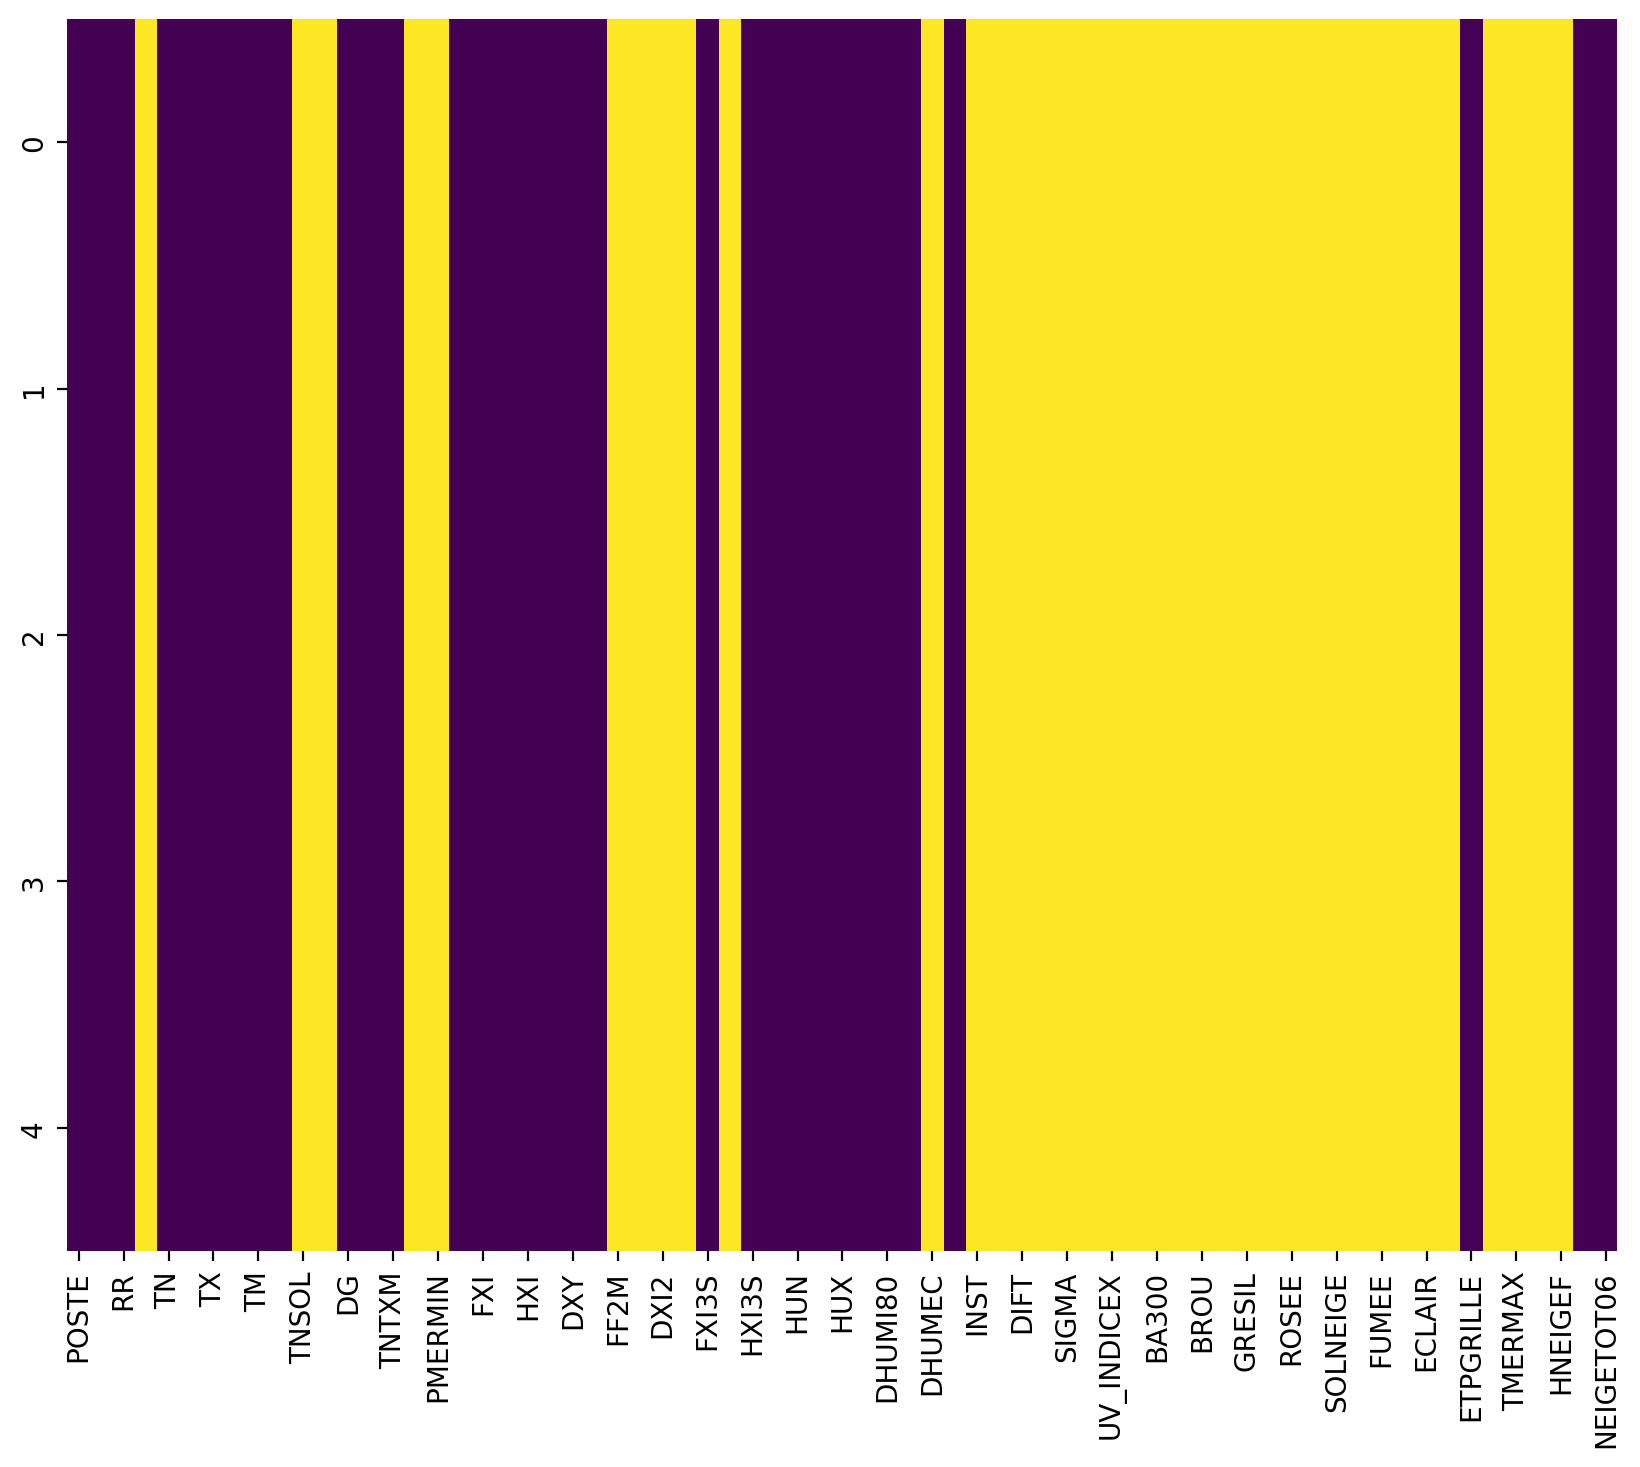

In [40]:
# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns

for col in df.select_dtypes(include="number"):
    print(f'{col:-<50} {df[col].isna().sum()/df.shape[0]}') 

# Création de la heatmap des valeurs manquantes
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

In [41]:
# Suppression des variables avec des valeurs manquantes : 
# Supprimer les colonnes où toutes les valeurs sont NaN
df_cleaned = df.dropna(axis=1, how='all')

print("\nDataFrame après suppression des colonnes vides :")
print(df_cleaned)


DataFrame après suppression des colonnes vides :
     POSTE      DATE   RR    TN  HTN    TX   HTX   TM   TMNX  DG  ...   HUN  \
0  1014002  20241101  0,0   1,2  614  21,8  1238  8,6  11,50   0  ...  1358   
1  1014002  20241102  0,2  -0,3  510  18,1  1225  7,7   8,90   9  ...  1154   
2  1014002  20241103  0,0   3,6  728  19,2  1356  8,4  11,40   0  ...  1308   
3  1014002  20241104  0,2   0,4  657  20,9  1252  8,1  10,65   0  ...  1259   
4  1014002  20241105  0,0   2,1  323  20,8  1216  9,4  11,45   0  ...  1156   

    UX  HUX DHUMI40  DHUMI80  TSVM  UM  ETPGRILLE  NEIGETOTX NEIGETOT06  
0  100  135       0     1002   9,2  84        1,3          0          0  
1  100  211       0     1073   9,3  89        0,8          0          0  
2  100  108       0     1052   9,6  88        1,2          0          0  
3  100   48       0     1000   9,0  85        1,2          0          0  
4  100    1       0      998   9,8  85        1,2          0          0  

[5 rows x 32 columns]


<Axes: >

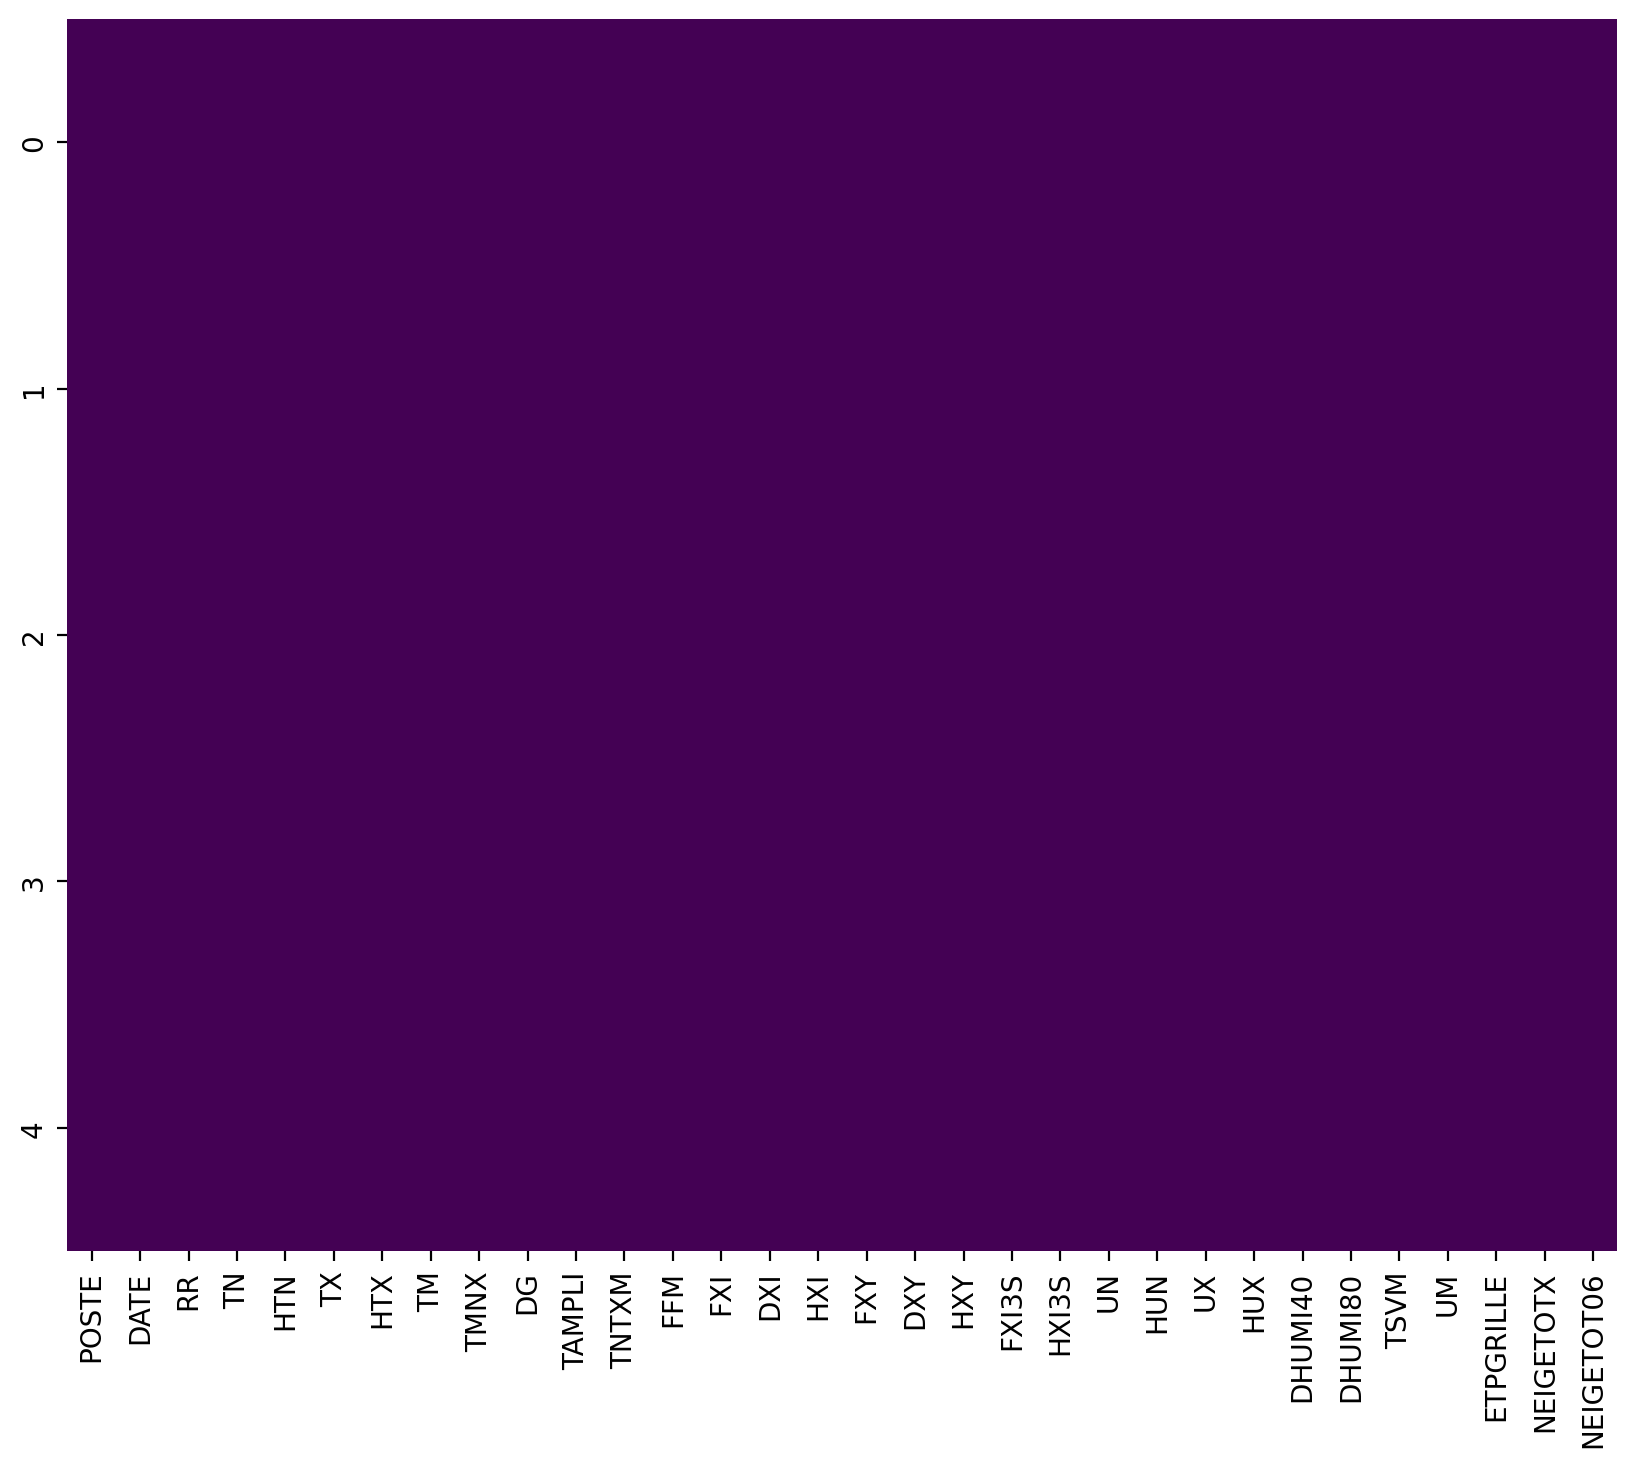

In [42]:
# Création de la heatmap des valeurs manquantes dans la base df_cleaned
plt.figure(figsize=(10,8))
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')

In [43]:
# Obtenir la liste des variables (colonnes)
variables = df_cleaned.columns.tolist()

# Afficher les variables
print("Liste des variables :")
print(variables)

Liste des variables :
['POSTE', 'DATE', 'RR', 'TN', 'HTN', 'TX', 'HTX', 'TM', 'TMNX', 'DG', 'TAMPLI', 'TNTXM', 'FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY', 'FXI3S', 'HXI3S', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80', 'TSVM', 'UM', 'ETPGRILLE', 'NEIGETOTX', 'NEIGETOT06']


In [44]:
import pandas as pd

# Séparer les variables qualitatives (catégorielles) et quantitatives
variables_quantitatives = df_cleaned.select_dtypes(include=['number']).columns.tolist()  # Variables numériques
variables_qualitatives = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()  # Variables catégorielles

# Afficher les résultats
print("Variables quantitatives :")
print(variables_quantitatives)

print("\nVariables qualitatives (catégorielles) :")
print(variables_qualitatives)


Variables quantitatives :
['POSTE', 'DATE', 'HTN', 'HTX', 'DG', 'DXI', 'HXI', 'DXY', 'HXY', 'HXI3S', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80', 'UM', 'NEIGETOTX', 'NEIGETOT06']

Variables qualitatives (catégorielles) :
['RR', 'TN', 'TX', 'TM', 'TMNX', 'TAMPLI', 'TNTXM', 'FFM', 'FXI', 'FXY', 'FXI3S', 'TSVM', 'ETPGRILLE']


#### Traitement des variables quantitatives

In [48]:
corr_matrix = df_cleaned.corr()
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')


ValueError: could not convert string to float: '0,0'